In [2]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import emcee
import pandas as pd
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM, LambdaCDM
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "figure.dpi": 150})

# Plotting functions

In [3]:
def plot_chains_traj(chains, param_names=0, axis_to_plot=[0,1]):
    if(chains.shape[1] != len(param_names)):
        param_names = [r"$\theta_" + str(i+1) + r"$" for i in range(len(chains))]
    fig, ax= plt.subplots(figsize=(8,5), dpi=120)
    for i in range(len(chains)):
        ax.plot(chains[i][axis_to_plot[0]], chains[i][axis_to_plot[1]], ".-", label="i = " + str(i))
    ax.set_xlabel(param_names[axis_to_plot[0]])
    ax.set_ylabel(param_names[axis_to_plot[1]])

def plot_param_chains(chains, param_names, burn=0):
    if(chains.shape[1] != len(param_names)):
        param_names = [r"$\theta_" + str(i+1) + r"$" for i in range(len(chains))]
    chains_nb = chains.T[burn:].T
    fig, ax = plt.subplots(chains.shape[1],figsize=(8,2.5*chains.shape[1]), dpi=120)
    for i in range(chains.shape[1]):
        for j in range(chains.shape[0]):
            ax[i].plot(range(len(chains_nb[j][i])),chains_nb[j][i],alpha=0.5)
        ax[i].set_ylabel(param_names[i])
    ax[i].set_xlabel('Iterations')
    ax[0].set_title('Chains')
    return chains_nb


def triangle_plot(chains_nb, param_names, dpi=200):
    chains_concat = np.zeros(chains_nb.shape[1])
    for i in range(len(chains_nb)):
        chains_concat = np.vstack([chains_concat,chains_nb[i].T])
    chains_concat = np.array(chains_concat[1:])
    samples = MCSamples(samples=np.array(chains_concat), names=param_names, labels=param_names)
    plots.GetDistPlotSettings(subplot_size_inch=2)
    g = plots.get_subplot_plotter(rc_sizes=(16,16,16))
    g.triangle_plot(samples, filled=True,title_limit=1)
    return samples

def mod_exp_comparison(dists):
    mu_fit, z_fit = mu_z(dists.means)
    fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)
    ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck")
    ax.plot(z_fit,mu_fit,"r",label=r"Fit")
    ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",ms=2,label=r"Experimental")
    ax.set_ylim(21,49)
    ax.set_xlim(-0.1,2.1)
    ax.set_xlabel(r"$z$")
    ax.set_ylabel(r"$\mu\left(z\right)$")
    ax.set_title(r"Model vs experimetal data vs Planck parameters")
    plt.legend(fontsize=14)


# MCMC functions

In [4]:
def lnprior(theta,lims):
    lnpr = np.zeros(len(theta))
    # if(theta[0]+theta[1] > 1):
    #     return -1*np.inf
    for i in range(len(theta)):
        if(lims[i][0] < theta[i] and theta[i] < lims[i][1]):
            lnpr[i] = -1*np.log(1/(lims[i][1]-lims[i][0]))
        else:
            lnpr[i] = -1*np.inf
    return sum(lnpr)

def lnlikelihood(data, theta, model, dev=0):
    if(np.any(dev == 0)):
        dev = np.ones(len(data[0]))
    return -1/2*np.sum(((data[1] - model(data[0],theta))/dev)**2 - np.log(2*np.pi*dev**2))

def mcmc(data, model, lims_prior, dispersion_trial, theta_start = [0,0], n_steps=250, max_it=1000, dev=0):
    theta_chain = [theta_start]
    lnposterior_i = lnlikelihood(data, theta_chain[-1:][0], model, dev=dev) + lnprior(theta_chain[-1:][0],lims_prior)
    it = 0
    while (len(theta_chain) < n_steps and it < max_it):
        it += 1
        theta_i = theta_chain[-1:][0]
        theta_trial = np.random.normal(theta_i,dispersion_trial)
        if(np.exp(lnprior(theta_trial,lims_prior)) == 0):
            lnposterior_trial = lnprior(theta_trial,lims_prior)
            p_acc = 0
        else:
            lnposterior_trial = lnlikelihood(data, theta_trial, model, dev=dev) + lnprior(theta_trial,lims_prior)
            p_acc = min(1,np.exp(lnposterior_trial-lnposterior_i))
        if(p_acc > np.random.uniform()):
            theta_chain.append(theta_trial)
            lnposterior_i = lnposterior_trial
    return np.array(theta_chain).T

# My $\mu(z)$ model functions

In [5]:
# integral resolution
resolution = 1000

def adot_lcdm(a,params):
    return params[0]*np.sqrt(params[1]*a**(-1) + params[2]*a**(2) + params[3]*a**(-2))

# numerical integration simpson's method 
def integral_simpson(f,t):
    t_new = []
    integral = []
    integral_sum = 0
    for i in range(len(t)-1):
        t_new_point = (t[i] + t[i+1])/2
        t_new.append(t_new_point)
        integral_sum += (t[i+1] - t[i])*(f[i+1] + f[i])/2
        integral.append(integral_sum)
    return np.array(integral), np.array(t_new)

# distance modulus function
def mu_z(theta):
    om_m0 = theta[0]
    om_l0 = theta[1]
    # radiation parameter
    om_g0 = 1 - (om_m0 + om_l0)
    # om_g0 = 0
    h_0 = 67.36*(1/3.086e+19)*(60*60*24*365)
    params = [h_0, om_m0, om_l0, om_g0]
    # compute proper distance
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)
    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0
    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)
    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    return mu, z_new

def mu_inter(z_arg, theta):
    mu,z = mu_z(theta)
    mu_interf = interp1d(z, mu, kind="linear", fill_value="extrapolate")
    return mu_interf(z_arg)


### Experimental data and my $\mu(z)$ with Planck colaboration parameters visualization

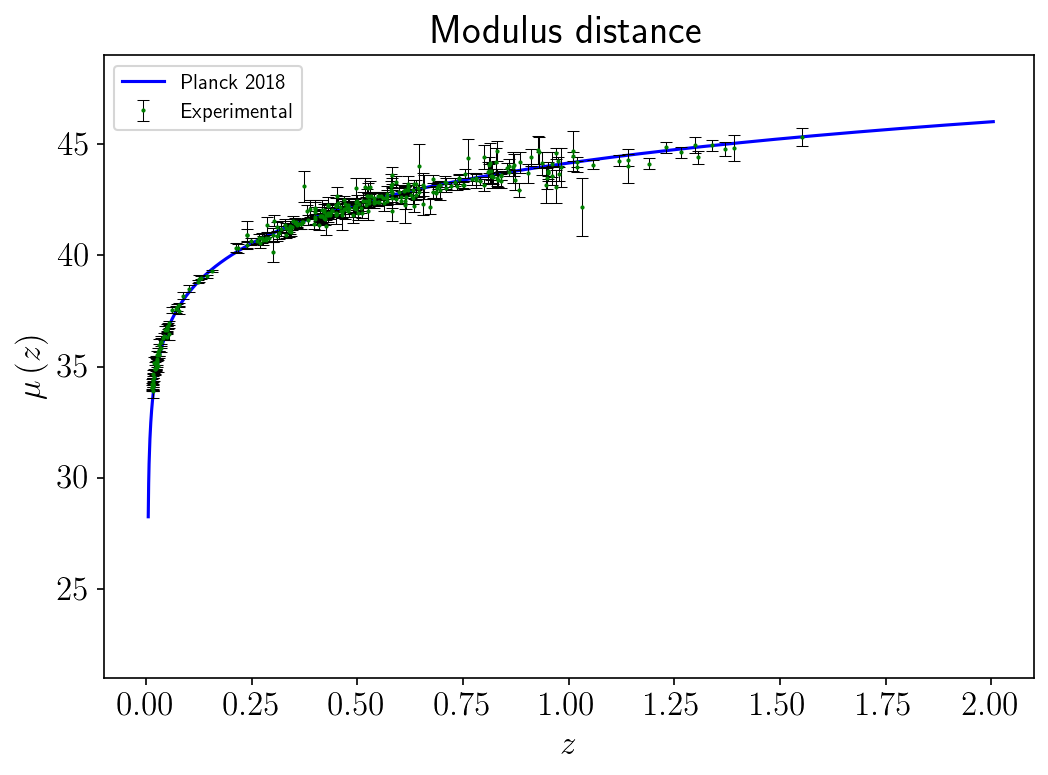

In [7]:
# density parameters L-CDM
om_m0 = 0.3153
om_l0 = 1 - om_m0

# get L-CDM mu(z) function
mu_lcdm, z_lcdm = mu_z([om_m0, om_l0])

# read experimental data
df_mu = pd.read_csv("mu.csv")
z_exp = np.array(df_mu["z"])
mu_exp = np.array(df_mu["mu"])
error_exp = np.array(df_mu["error"])

# Plot
fig,ax = plt.subplots(figsize=(8,5.5),dpi=150)

ax.plot(z_lcdm,mu_lcdm,"b",label=r"Planck 2018")
ax.errorbar(z_exp,mu_exp,yerr=error_exp,fmt='g.',elinewidth=0.5,capthick=0.5,capsize=3,ecolor="k",ms=2,label=r"Experimental")

ax.set_ylim(21,49)
ax.set_xlim(-0.1,2.1)

#ax.grid()
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\mu\left(z\right)$")
ax.set_title(r"Modulus distance")
plt.legend(fontsize=10)

# **A1 runs**

## A1 settings

In [201]:
# setting prior and mu(z)

def lnprior(theta,lims):
    lnpr = np.zeros(len(theta))
    if(theta[0]+theta[1] > 1):
        return -1*np.inf
    for i in range(len(theta)):
        if(lims[i][0] < theta[i] and theta[i] < lims[i][1]):
            lnpr[i] = -1*np.log(1/(lims[i][1]-lims[i][0]))
        else:
            lnpr[i] = -1*np.inf
    return sum(lnpr)

def mu_z(theta):
    om_m0 = theta[0]
    om_l0 = theta[1]
    # radiation parameter
    om_g0 = 1 - (om_m0 + om_l0)
    # om_g0 = 0
    h_0 = 67.36*(1/3.086e+19)*(60*60*24*365)
    params = [h_0, om_m0, om_l0, om_g0]
    # compute proper distance
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)
    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0
    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)
    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    return mu, z_new


## A1 my MCMC

In [202]:
n_chains = 10
data = np.array([z_exp,mu_exp])
model = mu_inter
lims_prior = [[0,1],[0,1]]
dispersion_trial = [(lims[1]-lims[0])/400 for lims in lims_prior]
n_steps = 10000
max_it = 2000000
dev = error_exp

chains = []

for i in range(n_chains):
    chain = mcmc(data = data,
                model = model,
                lims_prior = lims_prior,
                dispersion_trial = dispersion_trial,
                theta_start = [np.random.uniform(0,0.5),np.random.uniform(0,0.5)],
                n_steps = n_steps,
                max_it = max_it,
                dev = dev)
    chains.append(chain)
chains = np.array(chains)

chains_mymu = chains

Removed no burn in


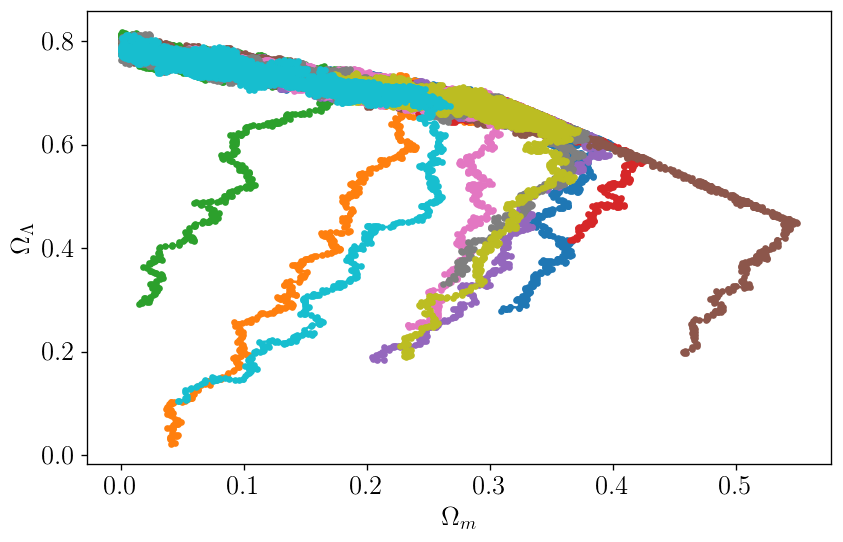

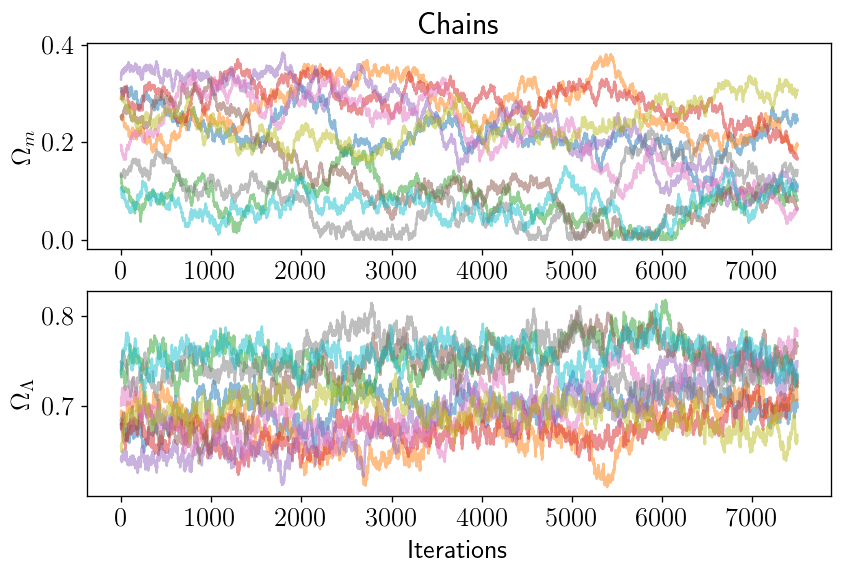

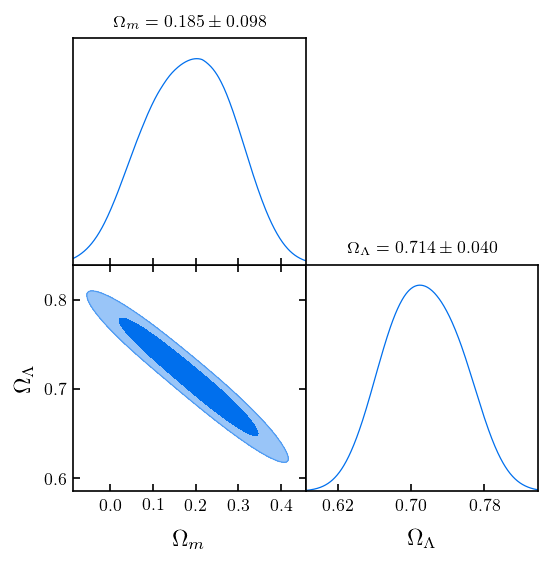

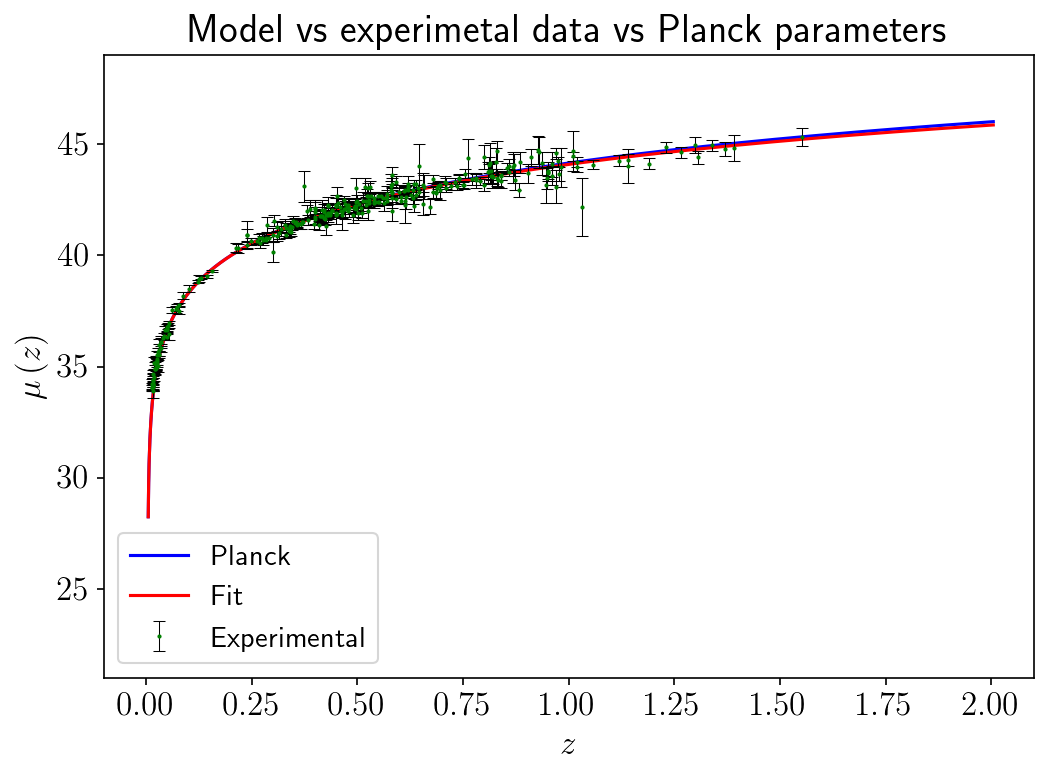

In [203]:
param_names = [r"$\Omega_m$", r"$\Omega_\Lambda$"]

plot_chains_traj(chains = chains_mymu,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_mymu_nb = plot_param_chains(chains = chains_mymu,
                                   param_names = param_names,
                                   burn=2500)

dists = triangle_plot(chains_nb = chains_mymu_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)


## A1 emcee

In [204]:
n_steps = 10000
n_chains = 10

lims = lims_prior
pos = np.array([[np.random.uniform(lims[0][0],lims[0][1]/2),np.random.uniform(lims[1][0],lims[1][1]/2)] for i in range(n_chains)])
nwalkers, ndim = pos.shape

def log_prior(theta):
    return lnprior(theta,lims)

def model_function(*args):
    return model(*args)

def log_likelihood(theta,x,y,yerr):
    return lnlikelihood([x,y],theta,model_function,yerr)

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

x, y, yerr = z_exp, mu_exp, error_exp

In [205]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos,n_steps, progress=True);

100%|██████████| 10000/10000 [05:15<00:00, 31.72it/s]


Removed no burn in


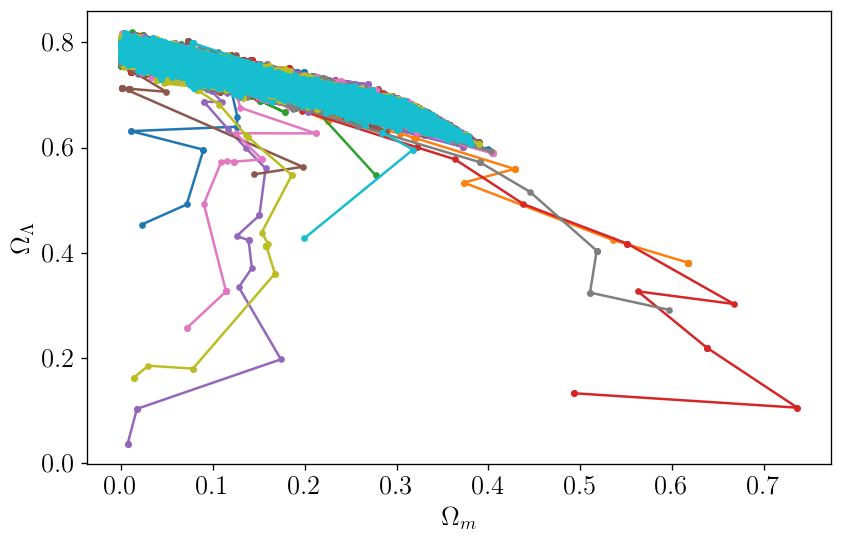

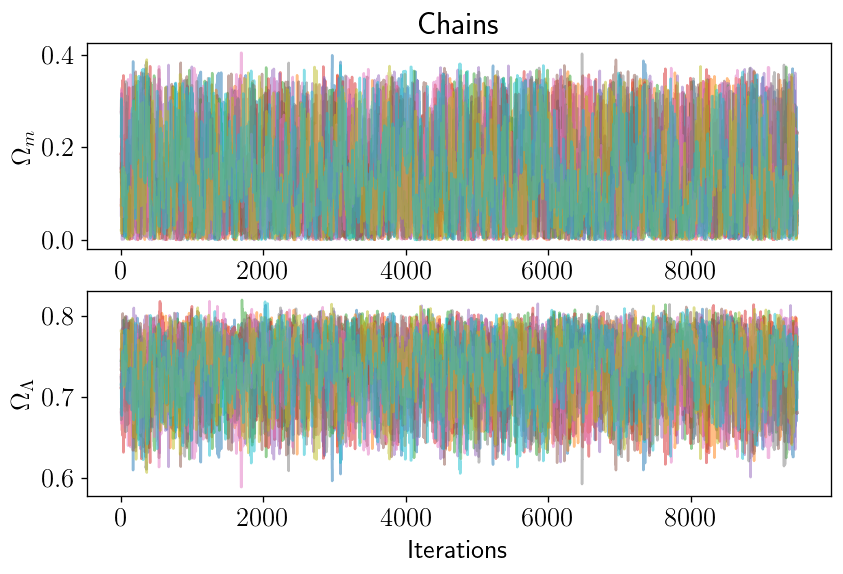

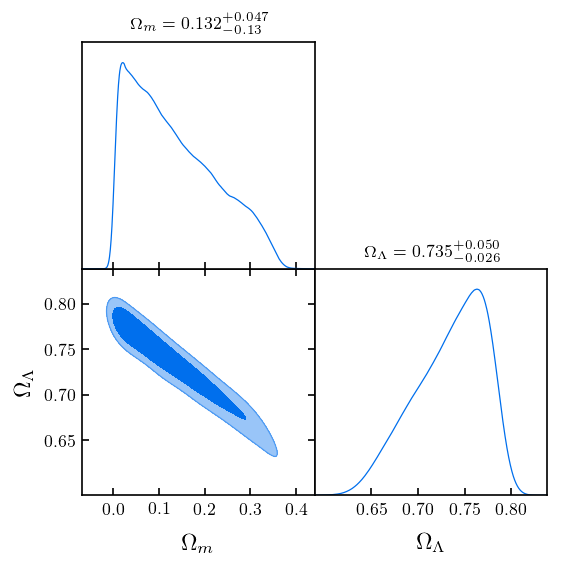

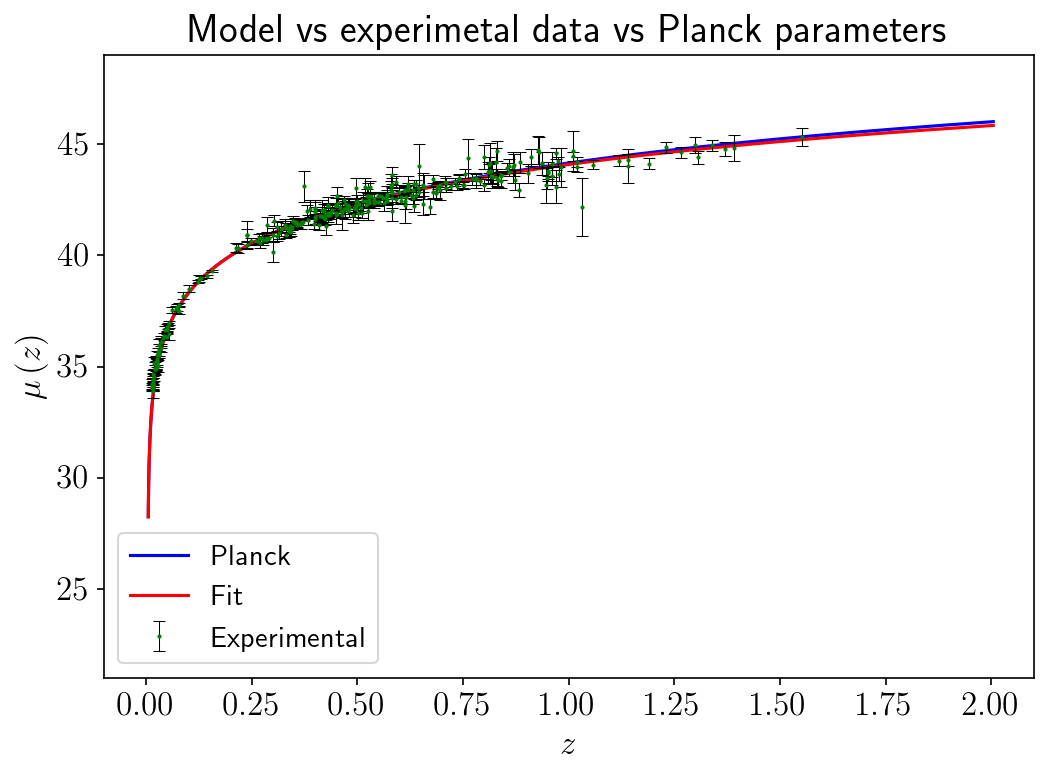

In [206]:
samples = sampler.get_chain()
reshaped = np.swapaxes(samples.T, 0, 1)
reshaped.shape

plot_chains_traj(chains = reshaped,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_nb = plot_param_chains(chains = reshaped,
                                    param_names = param_names,
                                    burn=500)

dists = triangle_plot(chains_nb = chains_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

# **A2 runs**

## A2 settings

In [16]:
# setting prior and mu(z)

def lnprior(theta,lims):
    lnpr = np.zeros(len(theta))
    for i in range(len(theta)):
        if(lims[i][0] < theta[i] and theta[i] < lims[i][1]):
            lnpr[i] = -1*np.log(1/(lims[i][1]-lims[i][0]))
        else:
            lnpr[i] = -1*np.inf
    return sum(lnpr)

def mu_z(theta):
    om_m0 = theta[0]
    om_l0 = theta[1]
    # radiation parameter
    # om_g0 = 1 - (om_m0 + om_l0)
    om_g0 = 0
    h_0 = 67.36*(1/3.086e+19)*(60*60*24*365)
    params = [h_0, om_m0, om_l0, om_g0]
    # compute proper distance
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)
    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0
    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)
    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    return mu, z_new



## A2 my MCMC

In [208]:
n_chains = 10
data = np.array([z_exp,mu_exp])
model = mu_inter
lims_prior = [[0,1.5],[0,1.5]]
dispersion_trial = [(lims[1]-lims[0])/200 for lims in lims_prior]
n_steps = 10000
max_it = 2000000
dev = error_exp

chains = []

for i in range(n_chains):
    chain = mcmc(data = data,
                model = model,
                lims_prior = lims_prior,
                dispersion_trial = dispersion_trial,
                theta_start = [np.random.uniform(0,0.5),np.random.uniform(0,0.5)],
                n_steps = n_steps,
                max_it = max_it,
                dev = dev)
    chains.append(chain)
chains = np.array(chains)

chains_mymu = chains

C:\Users\tu_rk\AppData\Local\Temp\ipykernel_11724\2783983639.py:30: RuntimeWarning: overflow encountered in exp
  p_acc = min(1,np.exp(lnposterior_trial-lnposterior_i))


Removed no burn in


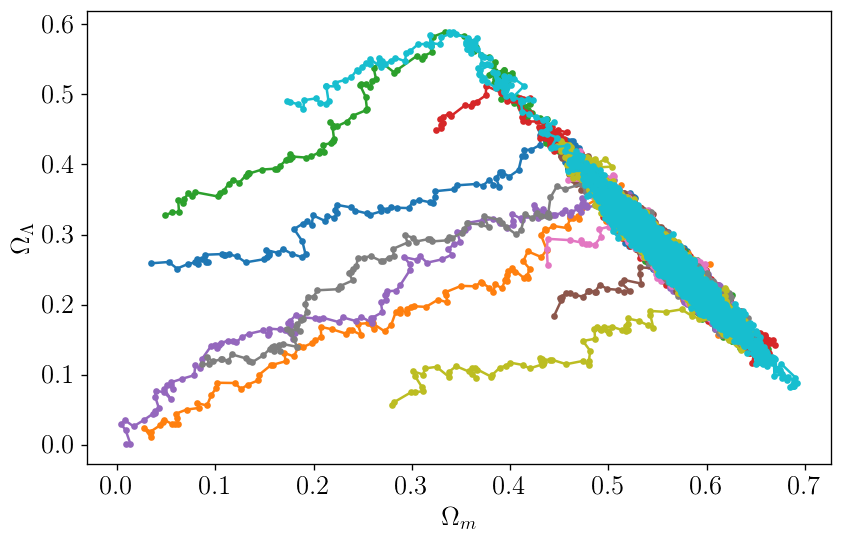

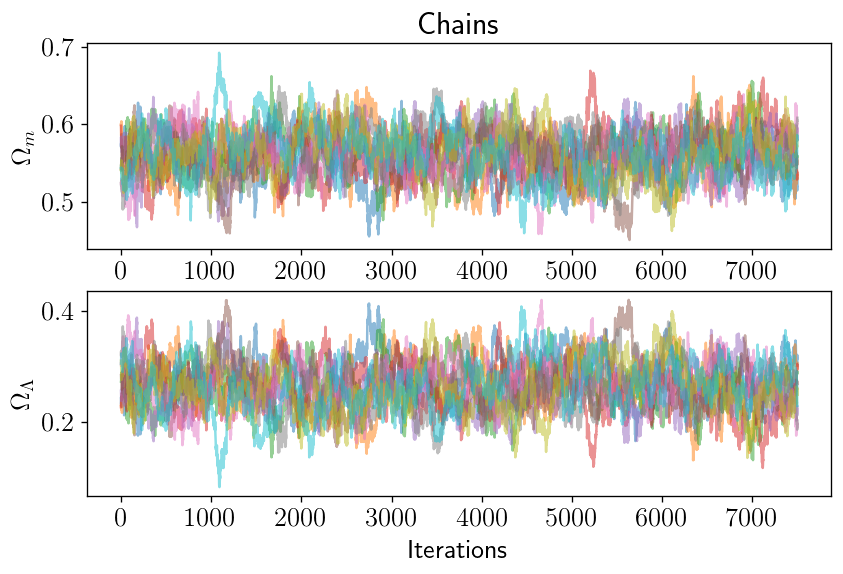

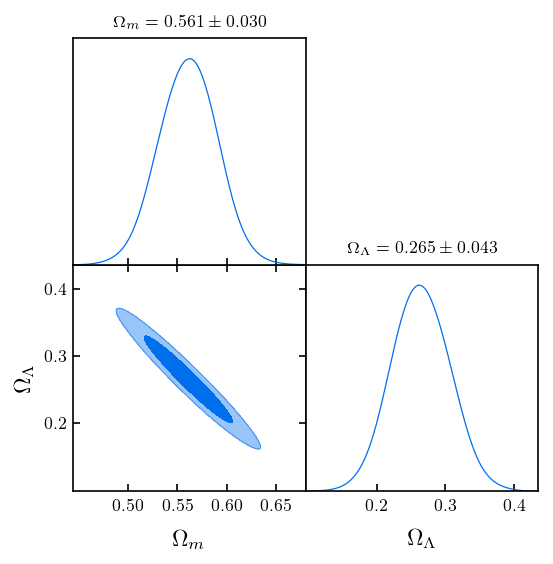

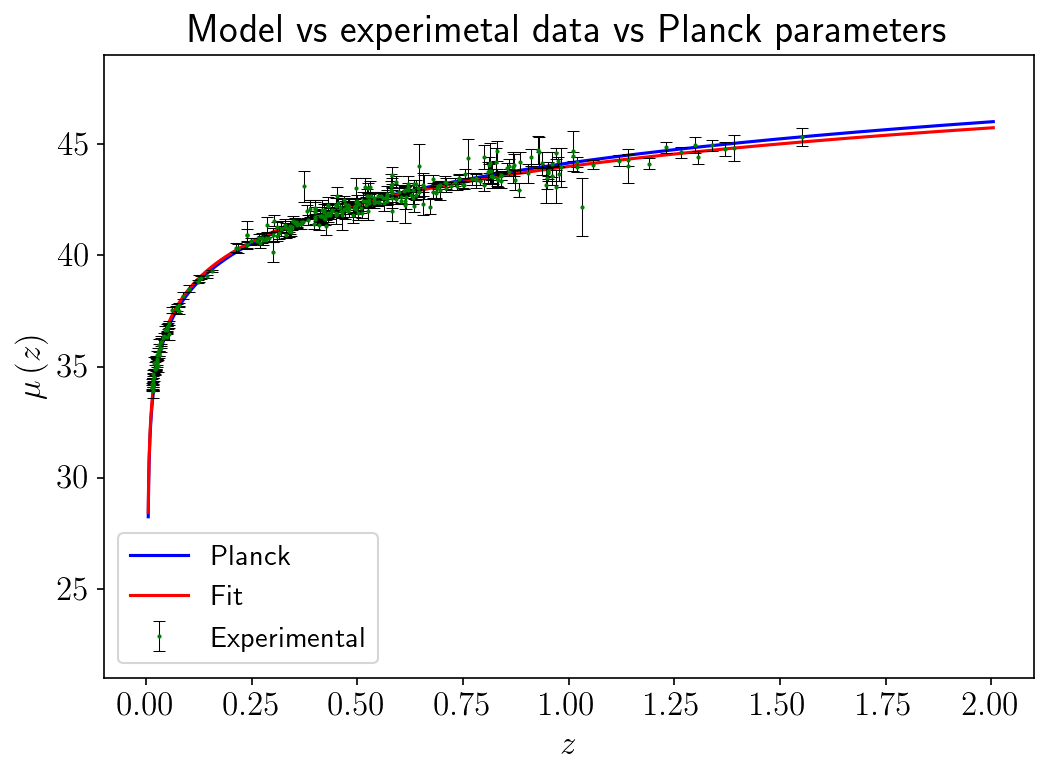

In [209]:
param_names = [r"$\Omega_m$", r"$\Omega_\Lambda$"]

plot_chains_traj(chains = chains_mymu,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_mymu_nb = plot_param_chains(chains = chains_mymu,
                                   param_names = param_names,
                                   burn=2500)

dists = triangle_plot(chains_nb = chains_mymu_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

## A2 emcee

In [17]:
n_steps = 10000
n_chains = 10
lims_prior = [[0,1.5],[0,1.5]]
lims = lims_prior
pos = np.array([[np.random.uniform(lims[0][0],lims[0][1]),np.random.uniform(lims[1][0],lims[1][1])] for i in range(n_chains)])
nwalkers, ndim = pos.shape

def log_prior(theta):
    return lnprior(theta,lims)

def model_function(*args):
    return mu_inter(*args)

def log_likelihood(theta,x,y,yerr):
    return lnlikelihood([x,y],theta,model_function,yerr)

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

x, y, yerr = z_exp, mu_exp, error_exp

In [211]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos,n_steps, progress=True);

100%|██████████| 10000/10000 [07:00<00:00, 23.76it/s]


Removed no burn in


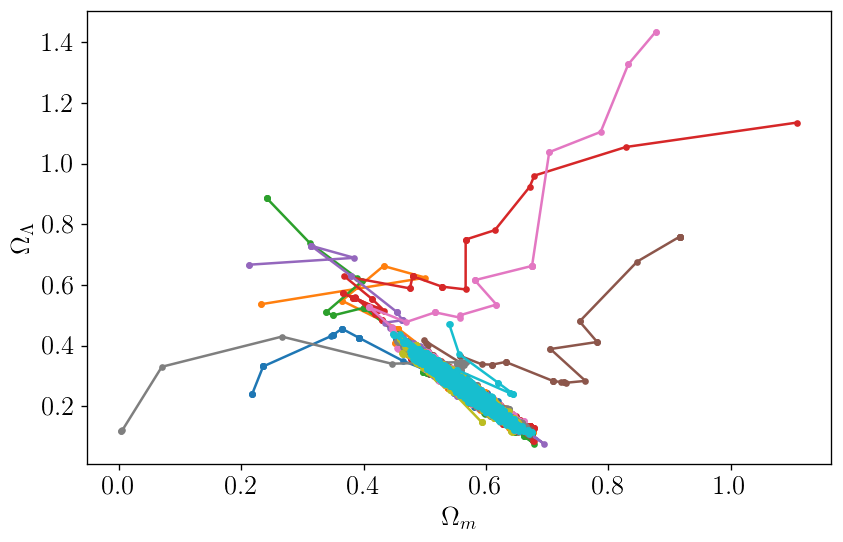

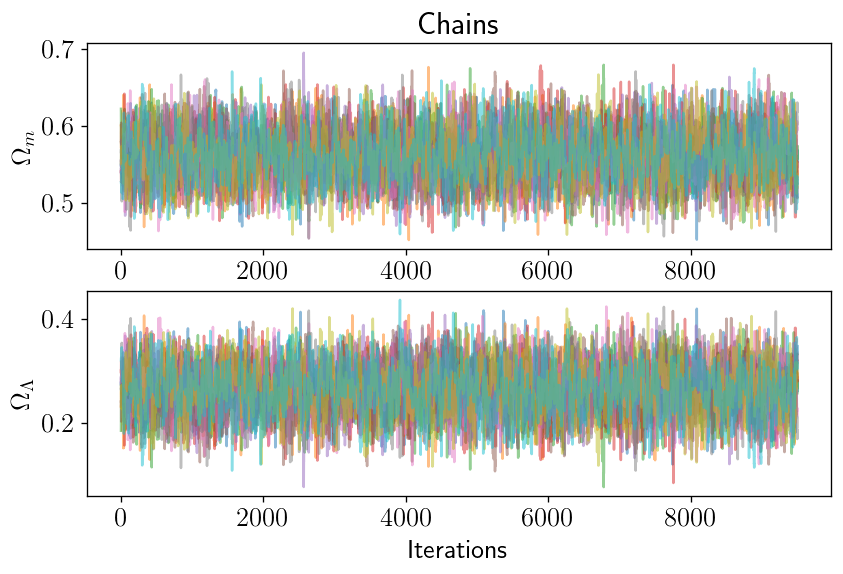

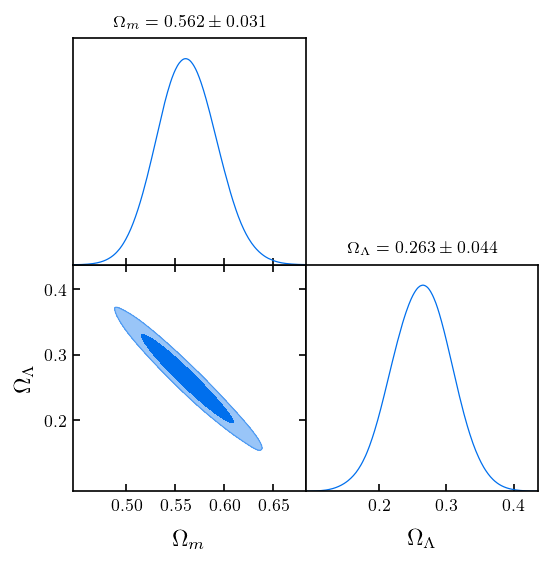

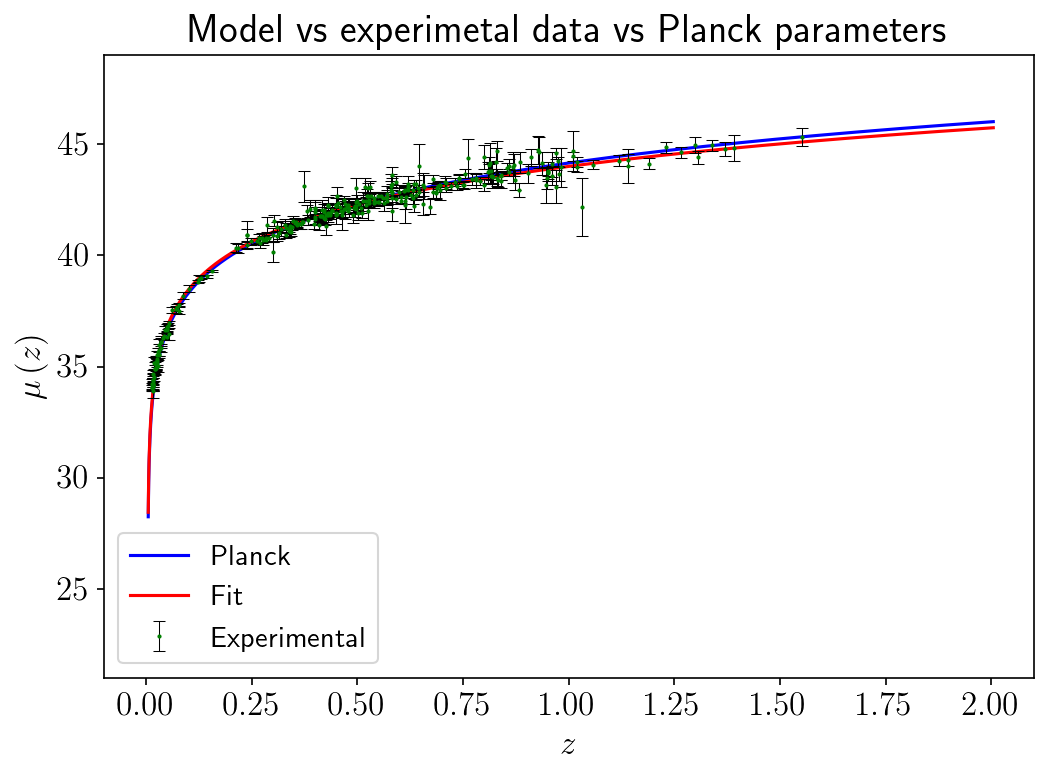

In [212]:
samples = sampler.get_chain()
reshaped = np.swapaxes(samples.T, 0, 1)
reshaped.shape

plot_chains_traj(chains = reshaped,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_nb = plot_param_chains(chains = reshaped,
                                    param_names = param_names,
                                    burn=500)

dists = triangle_plot(chains_nb = chains_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

## A2 Settings for runs with astropy $\mu(z)$ functions

In [11]:
def lumdist(z,om_m0,om_l0):
  cosmo = LambdaCDM(H0=67.36, Om0=om_m0, Ode0=om_l0, Tcmb0=2.725)
  return  cosmo.luminosity_distance(z) 

In [12]:
def mu_astropy(z,theta):
  om_m0 = theta[0]
  om_l0 = theta[1]
  DL = lumdist(z,om_m0,om_l0)   
  return 5. * np.log10(DL.value)+25

## A2 my MCMC astropy

In [21]:
n_chains = 10

chains = []

for i in range(n_chains):
    chain = mcmc(data = np.array([z_exp,mu_exp]),
                model = mu_astropy,
                lims_prior = [[0,1],[0,1]],
                dispersion_trial = [0.005,0.005],
                theta_start = [np.random.uniform(0,0.5),np.random.uniform(0,0.5)],
                n_steps = 10000,
                max_it = 2000000,
                dev = error_exp)
    chains.append(chain)
chains = np.array(chains)

chains_astmu = chains


Removed no burn in


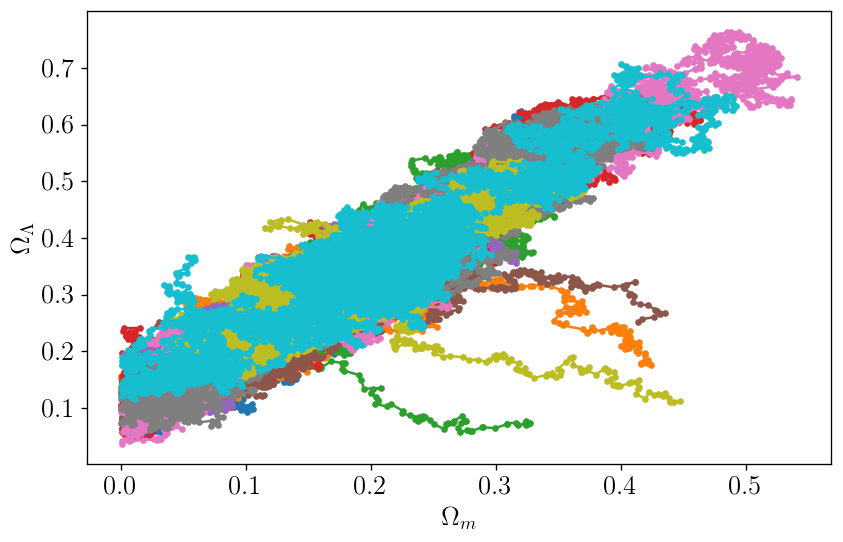

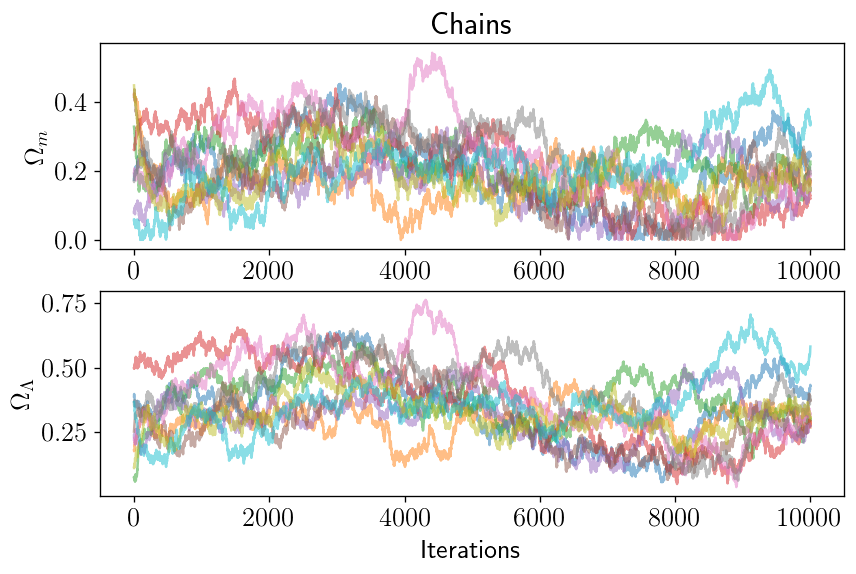

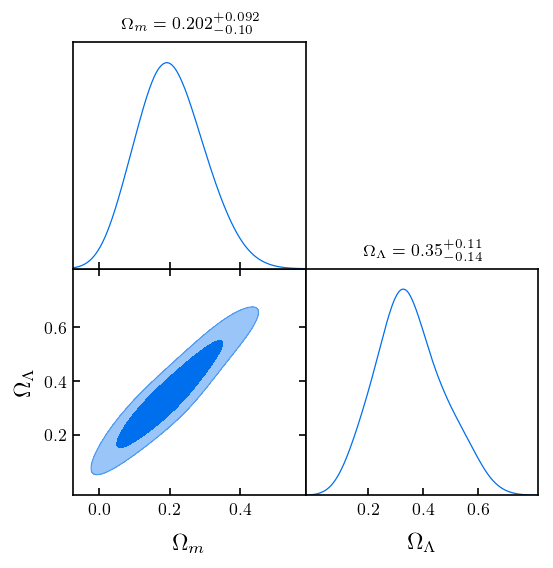

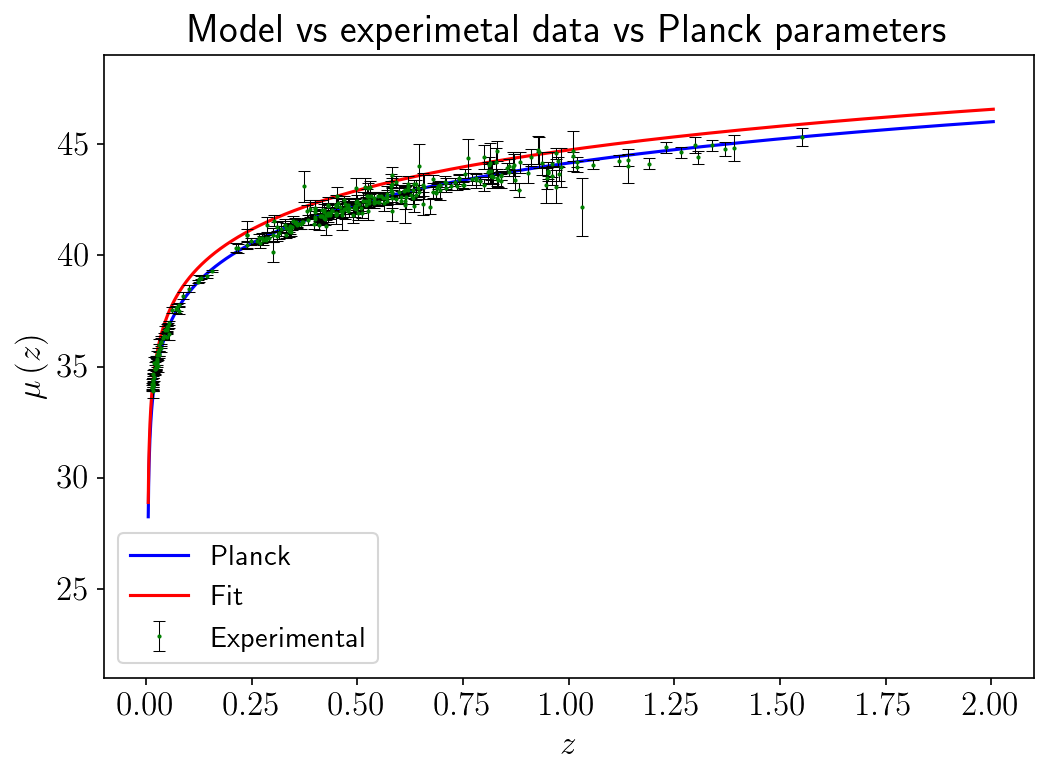

In [22]:
param_names = [r"$\Omega_m$",r"$\Omega_\Lambda$"]

plot_chains_traj(chains = chains_astmu,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_astmu_nb = plot_param_chains(chains = chains_astmu,
                                    param_names = param_names,
                                    burn=0)

dists = triangle_plot(chains_nb = chains_astmu_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)


## A2 emcee astropy

In [18]:
lims = [[0,1.5],[0,1.5]]
def log_prior(theta):
    return lnprior(theta,lims)

def model_function(*args):
    return mu_astropy(*args)

def log_likelihood(theta,x,y,yerr):
    return lnlikelihood([x,y],theta,model_function,yerr)

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

x, y, yerr = z_exp, mu_exp, error_exp

In [19]:
import emcee

pos = np.array([[np.random.uniform(0,1),np.random.uniform(0,1)] for i in range(10)])
nwalkers, ndim = pos.shape


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [04:34<00:00, 36.43it/s]


Removed no burn in


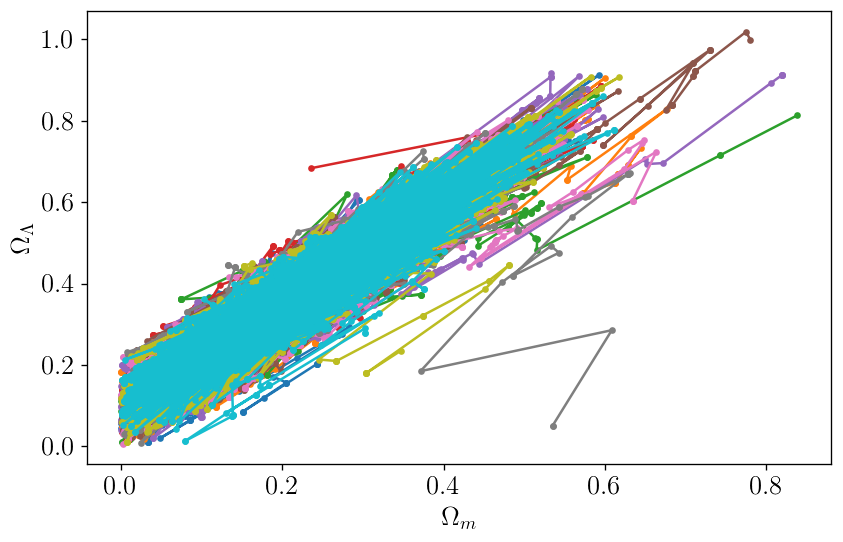

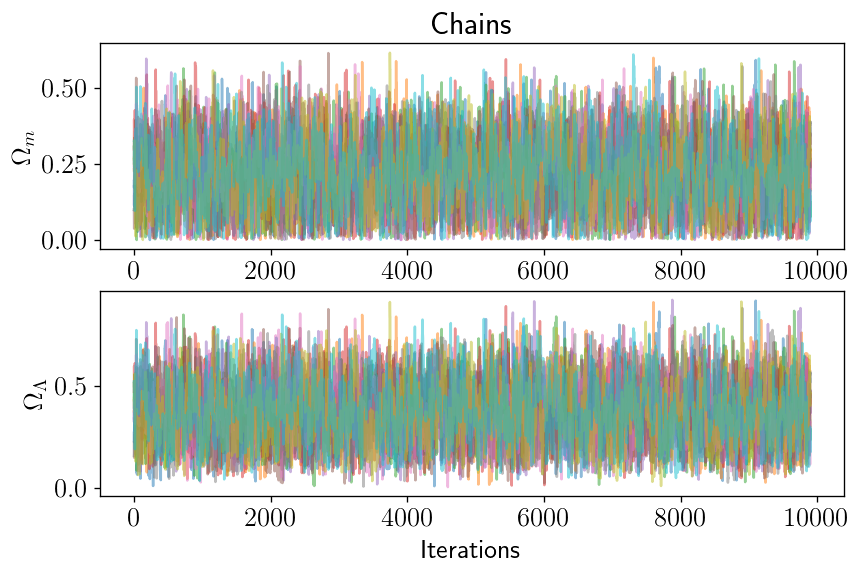

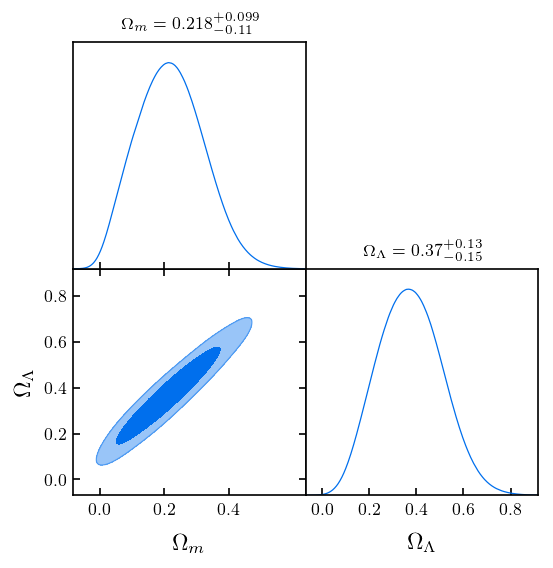

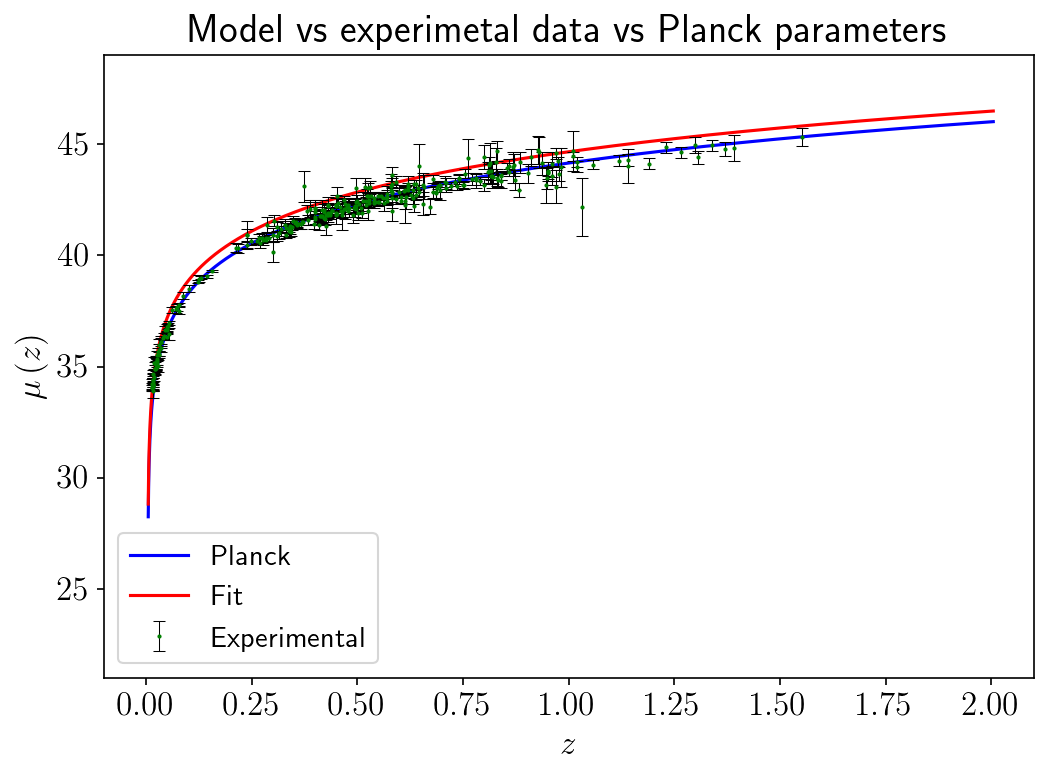

In [20]:
samples = sampler.get_chain()
reshaped = np.swapaxes(samples.T, 0, 1)
reshaped.shape


param_names = [r"$\Omega_m$",r"$\Omega_\Lambda$"]

plot_chains_traj(chains = reshaped,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_nb = plot_param_chains(chains = reshaped,
                                    param_names = param_names,
                                    burn=100)

dists = triangle_plot(chains_nb = chains_nb,
                      param_names = ["\Omega_m","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

# **A3 runs**

## A3 Settings

In [213]:
# setting prior and mu(z)

def lnprior(theta,lims):
    lnpr = np.zeros(len(theta))
    for i in range(len(theta)):
        if(lims[i][0] < theta[i] and theta[i] < lims[i][1]):
            lnpr[i] = -1*np.log(1/(lims[i][1]-lims[i][0]))
        else:
            lnpr[i] = -1*np.inf
    return sum(lnpr)

def mu_z(theta):
    h_0 = theta[0]
    om_l0 = theta[1]
    
    # radiation parameter
    om_m0 = 1 - om_l0
    om_g0 = 0
    params = [h_0*(1/3.086e+19)*(60*60*24*365), om_m0, om_l0, om_g0]
    # compute proper distance
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)
    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0
    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)
    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    return mu, z_new


## A3 my MCMC 

In [214]:
n_chains = 10
data = np.array([z_exp,mu_exp])
model = mu_inter
lims_prior = [[50,100],[0,1]]
dispersion_trial = [(lims[1]-lims[0])/200 for lims in lims_prior]
n_steps = 10000
max_it = 20000
dev = error_exp

chains = []

for i in range(n_chains):
    chain = mcmc(data = data,
                model = model,
                lims_prior = lims_prior,
                dispersion_trial = dispersion_trial,
                theta_start = [np.random.uniform(50,100),np.random.uniform(0,1)],
                n_steps = n_steps,
                max_it = max_it,
                dev = dev)
    chains.append(chain)
chains = np.array(chains)

chains_mymu = chains

Removed no burn in


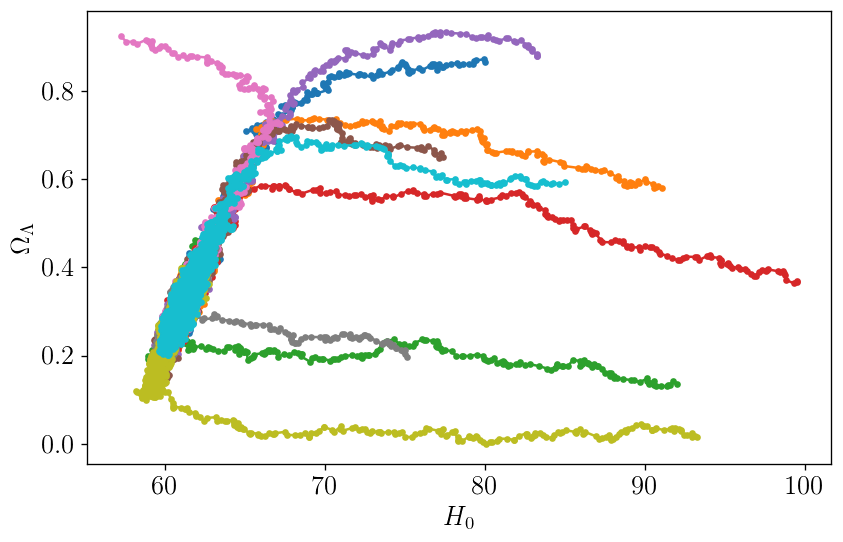

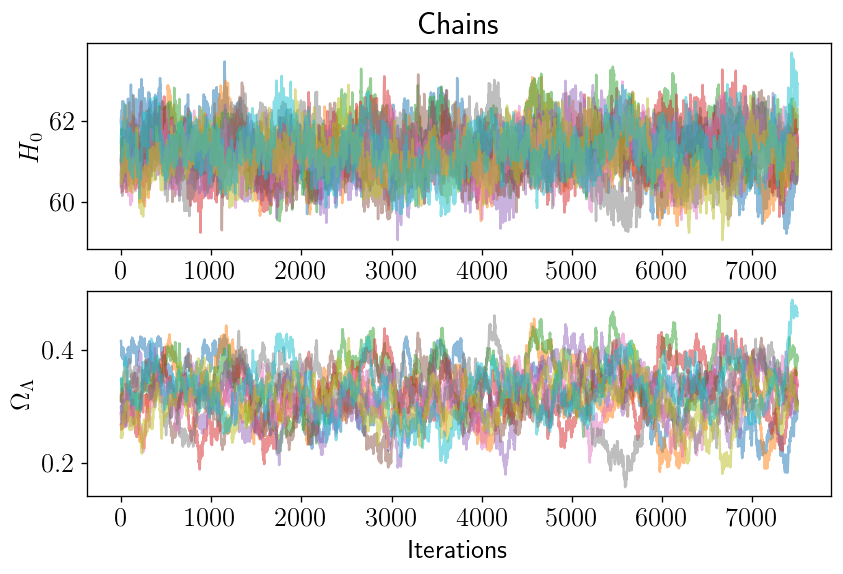

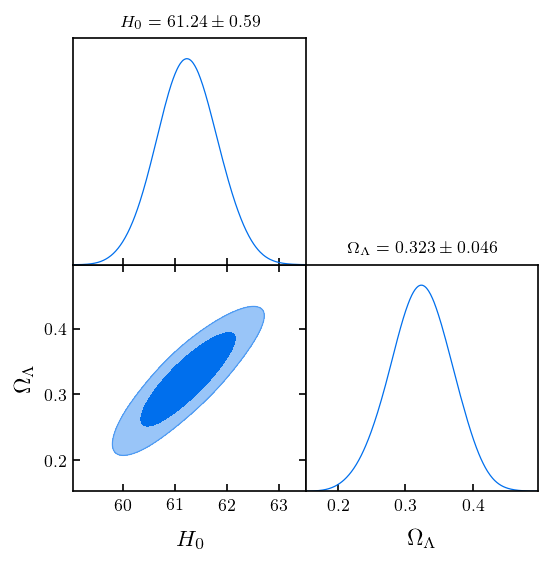

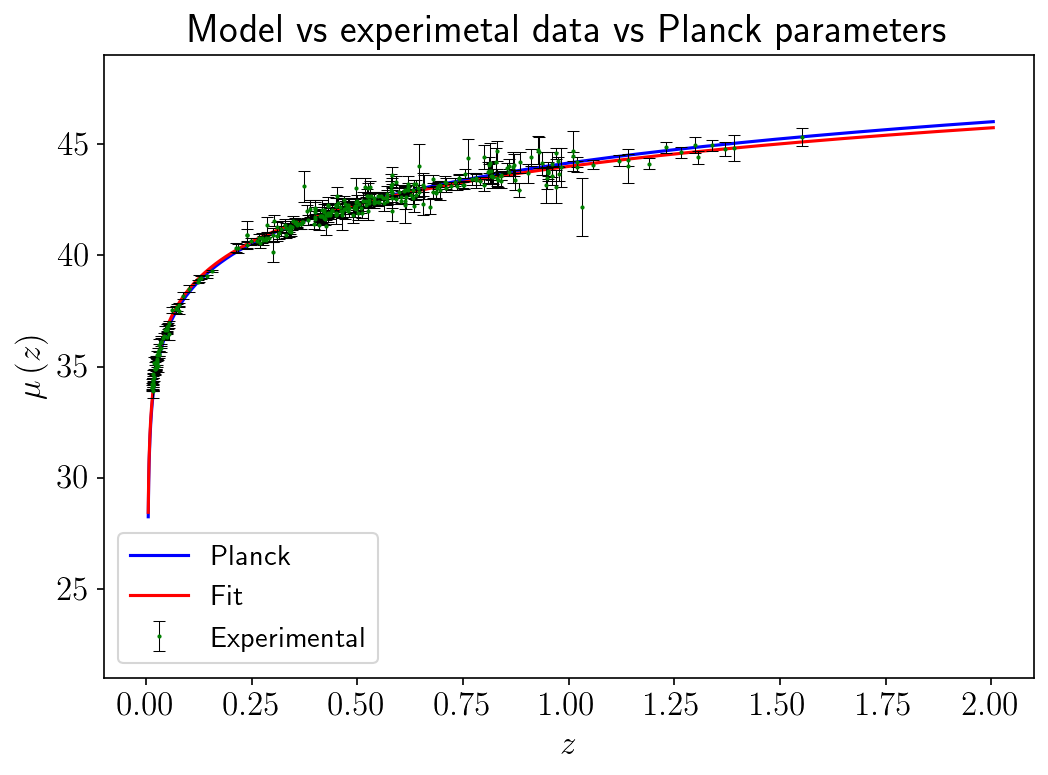

In [231]:
param_names = [r"$H_0$", r"$\Omega_\Lambda$"]

plot_chains_traj(chains = chains_mymu,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_mymu_nb = plot_param_chains(chains = chains_mymu,
                                   param_names = param_names,
                                   burn=2500)

dists = triangle_plot(chains_nb = chains_mymu_nb,
                      param_names = ["H_0","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

## A3 emcee

In [232]:
lims_prior = [[50,100],[0,1]]

n_steps = 10000
n_chains = 10

lims = lims_prior
pos = np.array([[np.random.uniform(lims[0][0],lims[0][1]),np.random.uniform(lims[1][0],lims[1][1])] for i in range(n_chains)])
nwalkers, ndim = pos.shape

def log_prior(theta):
    return lnprior(theta,lims)

def model_function(*args):
    return mu_inter(*args)

def log_likelihood(theta,x,y,yerr):
    return lnlikelihood([x,y],theta,model_function,yerr)

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

x, y, yerr = z_exp, mu_exp, error_exp

In [233]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos,n_steps, progress=True);

100%|██████████| 10000/10000 [07:25<00:00, 22.45it/s]


Removed no burn in


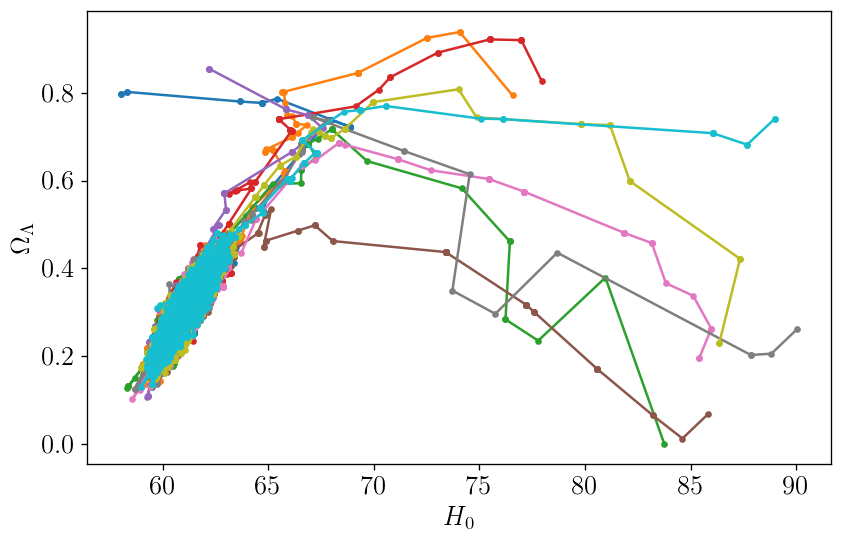

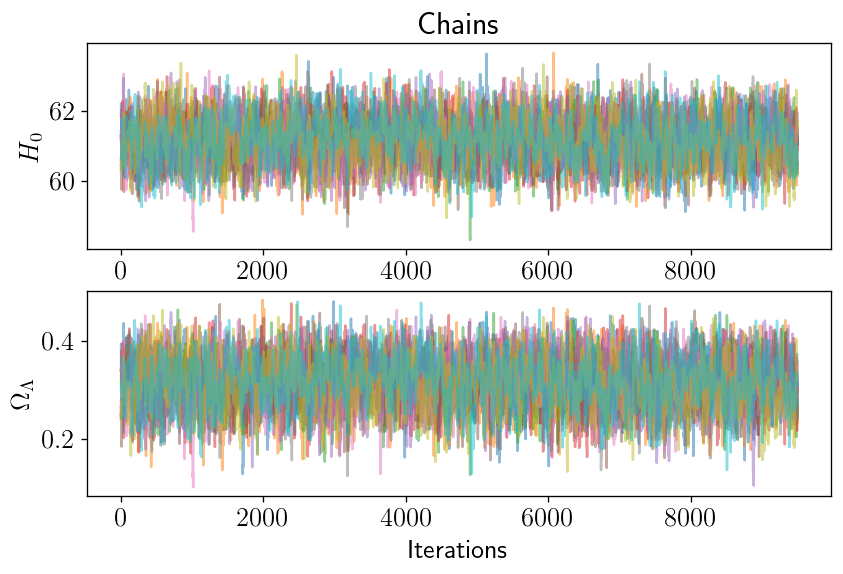

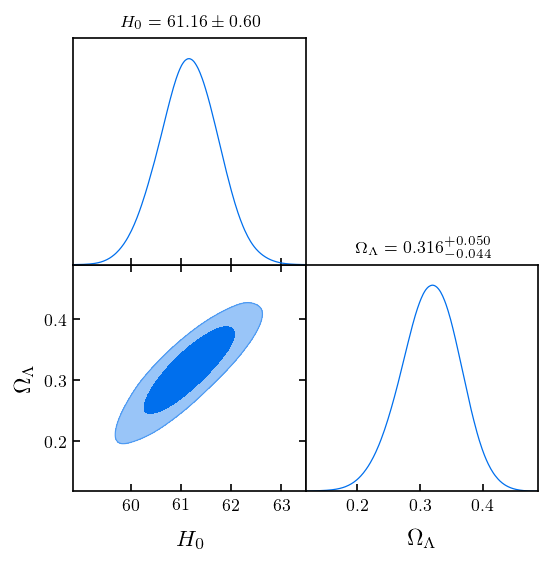

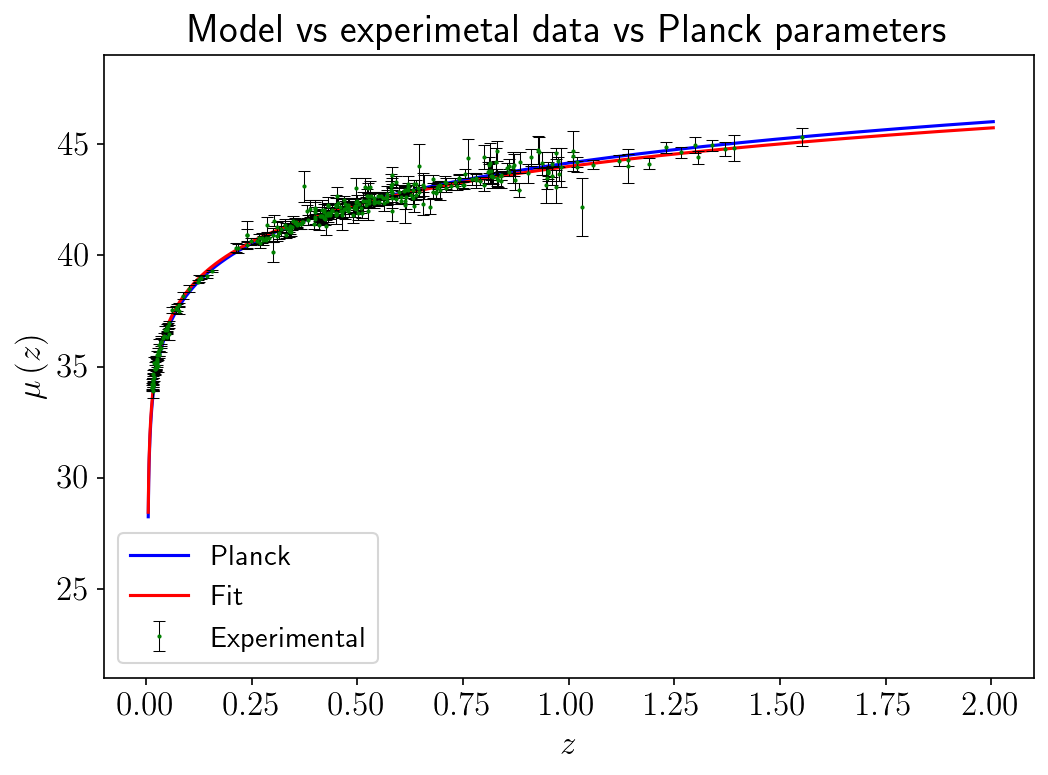

In [235]:
samples = sampler.get_chain()

reshaped = np.swapaxes(samples.T, 0, 1)
reshaped.shape

plot_chains_traj(chains = reshaped,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_nb = plot_param_chains(chains = reshaped,
                                    param_names = param_names,
                                    burn=500)

dists = triangle_plot(chains_nb = chains_nb,
                      param_names = ["H_0","\Omega_\Lambda"],
                      dpi = 100)

mod_exp_comparison(dists)

# **A4 runs**

## A4 settings

In [280]:
# integral resolution
resolution = 1000

def adot_lcdm(a,params):
    return params[0]*np.sqrt(params[1]*a**(-1) + params[2]*a**(-1-3*(params[3]+(1-a)*params[4])))


def mu_z(theta):
    om_l0 = theta[0]
    om_0 = theta[1]
    om_1 = theta[2]
    # radiation parameter
    om_m0 = 1 - om_l0
    h_0 = 67.36*(1/3.086e+19)*(60*60*24*365)
    params = [h_0, om_m0, om_l0, om_0, om_1]
    # compute proper distance
    z = np.linspace(5/resolution,2 + 5/resolution,resolution*2 + 1)
    a = 1/(z+1)
    f = a/(adot_lcdm(a,params))
    d_pt0, z_new = integral_simpson(f,z)
    # c factor missing after integration
    c = 3e8*(60*60*24*365)*(1/3.086e+22)
    d_pt0 = c*d_pt0
    # compute luminosity distance
    d_l = d_pt0*(1 + z_new)
    # compute the distance modulus
    mu = 5*np.log10(d_l) + 25
    return mu, z_new


## A4 my MCMC

In [285]:
n_chains = 10
data = np.array([z_exp,mu_exp])
model = mu_inter
lims_prior = [[0,1],[-3,1],[-2,2]]
dispersion_trial = [(lims[1]-lims[0])/200 for lims in lims_prior]
n_steps = 10000
max_it = 2000000
dev = error_exp

chains = []

for i in range(n_chains):
    chain = mcmc(data = data,
                model = model,
                lims_prior = lims_prior,
                dispersion_trial = dispersion_trial,
                theta_start = [np.random.uniform(0,1),np.random.uniform(0,-2),np.random.uniform(-1,1)],
                n_steps = n_steps,
                max_it = max_it,
                dev = dev)
    chains.append(chain)
chains = np.array(chains)

chains_A4M1 = chains

Removed no burn in


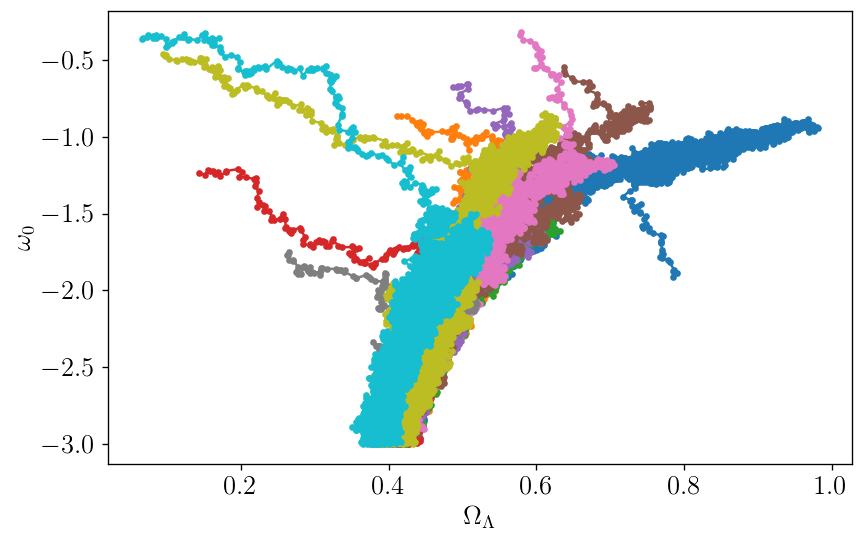

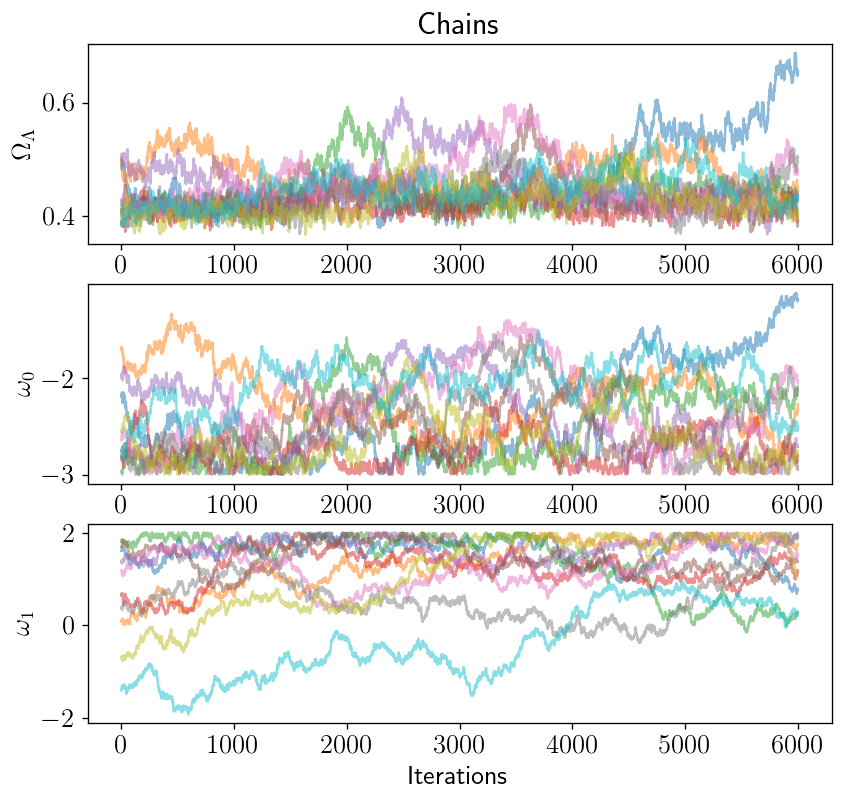

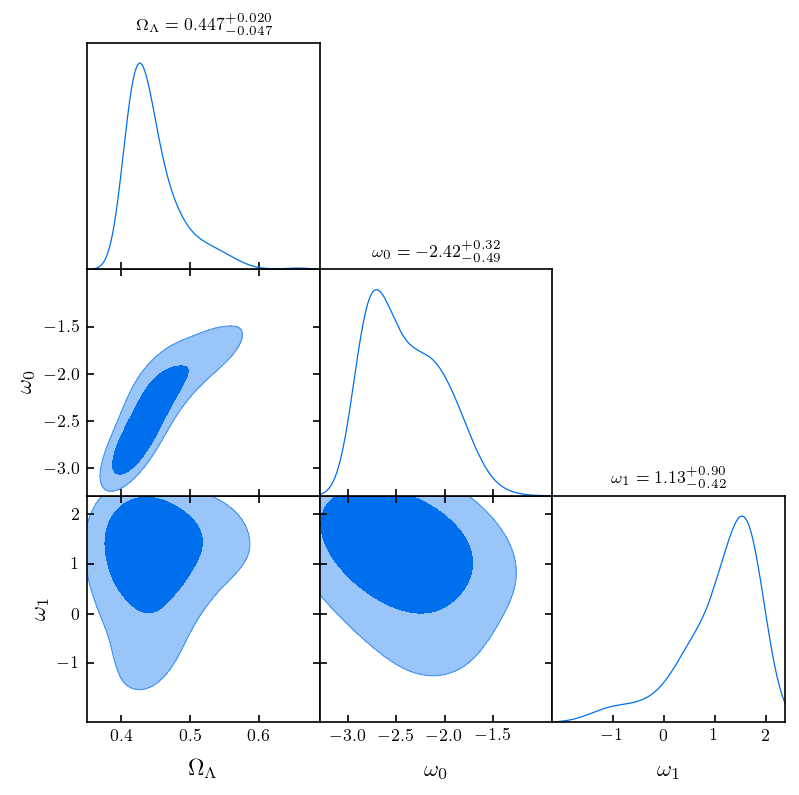

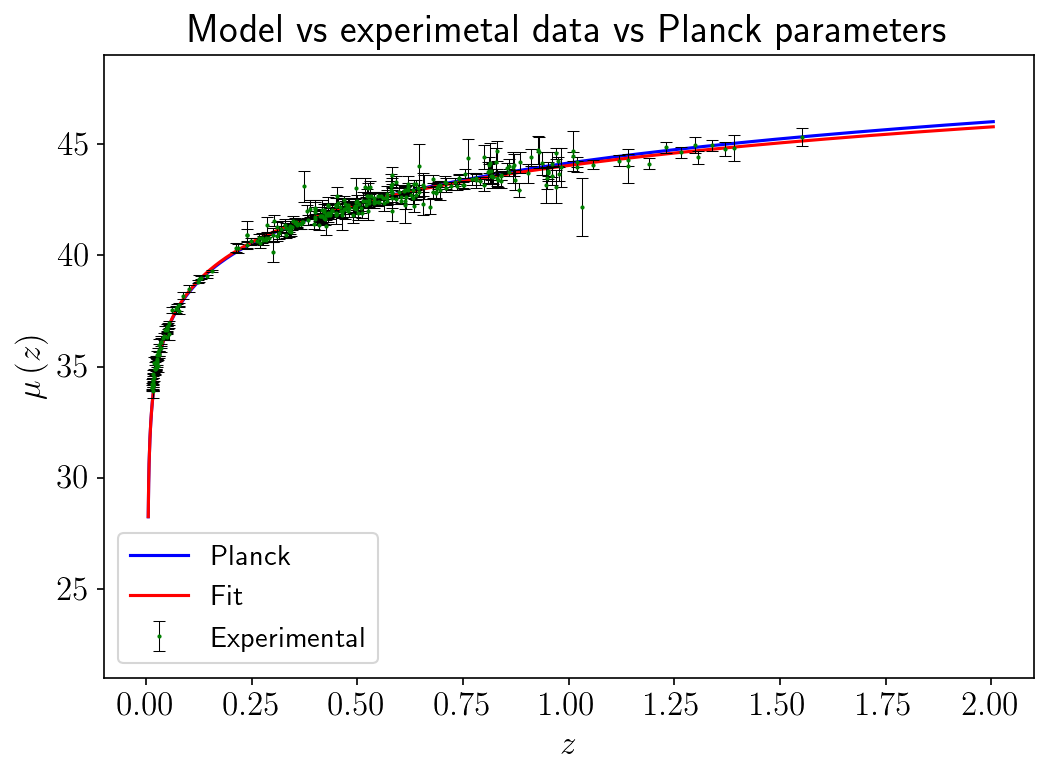

In [300]:
param_names = [r"$\Omega_\Lambda$",r"$\omega_0$", r"$\omega_1$"]

plot_chains_traj(chains = chains_A4M1,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_A4M1_nb = plot_param_chains(chains = chains_A4M1,
                                   param_names = param_names,
                                   burn=4000)

dists = triangle_plot(chains_nb = chains_A4M1_nb,
                      param_names = ["\Omega_\Lambda","\omega_0", "\omega_1"],
                      dpi = 100)

mod_exp_comparison(dists)

## A4 emcee

In [287]:
n_steps = 10000
n_chains = 10

lims = lims_prior
pos = np.array([[np.random.uniform(lims[i][0],lims[i][1]) for i in range(len(lims))] for j in range(n_chains)])
nwalkers, ndim = pos.shape

def log_prior(theta):
    return lnprior(theta,lims)

def model_function(*args):
    return mu_inter(*args)

def log_likelihood(theta,x,y,yerr):
    return lnlikelihood([x,y],theta,model_function,yerr)

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

x, y, yerr = z_exp, mu_exp, error_exp

In [288]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos,n_steps, progress=True);

100%|██████████| 10000/10000 [05:18<00:00, 31.44it/s]


Removed no burn in


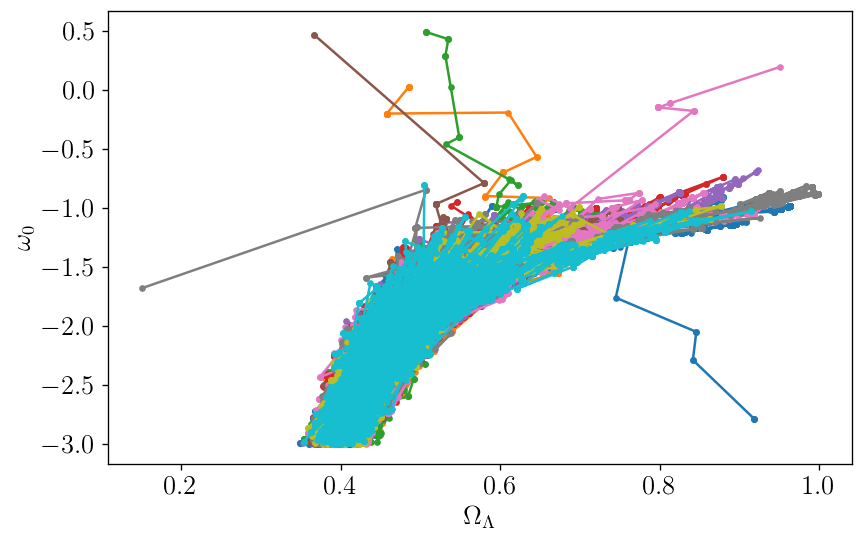

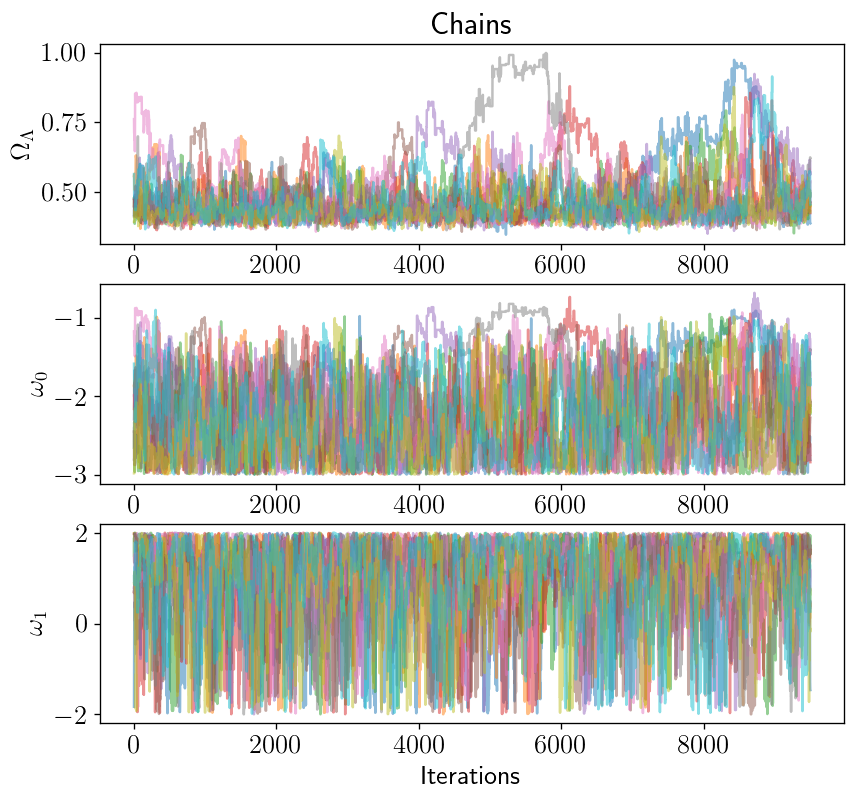

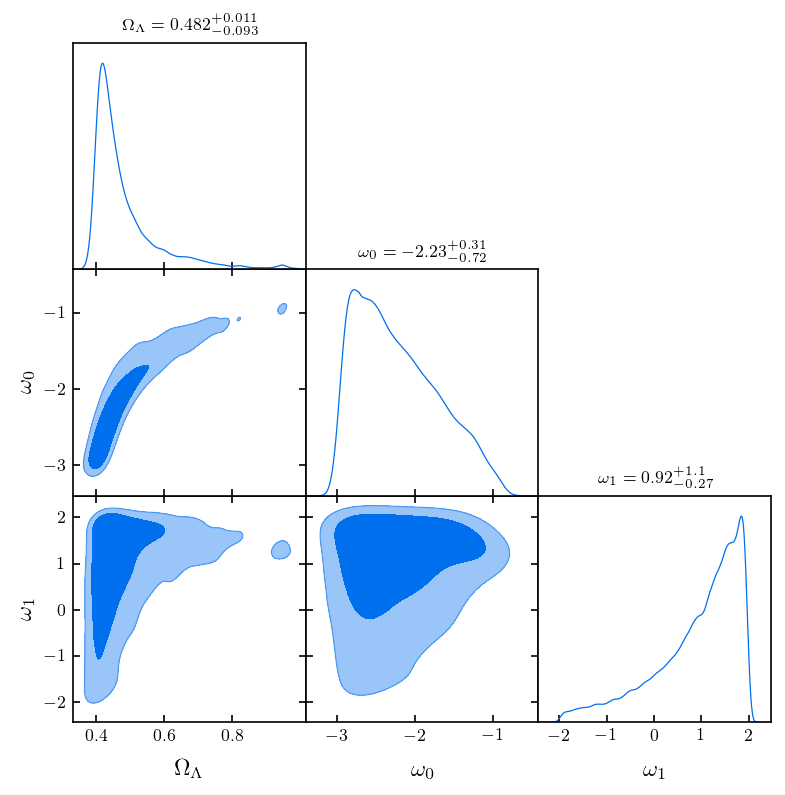

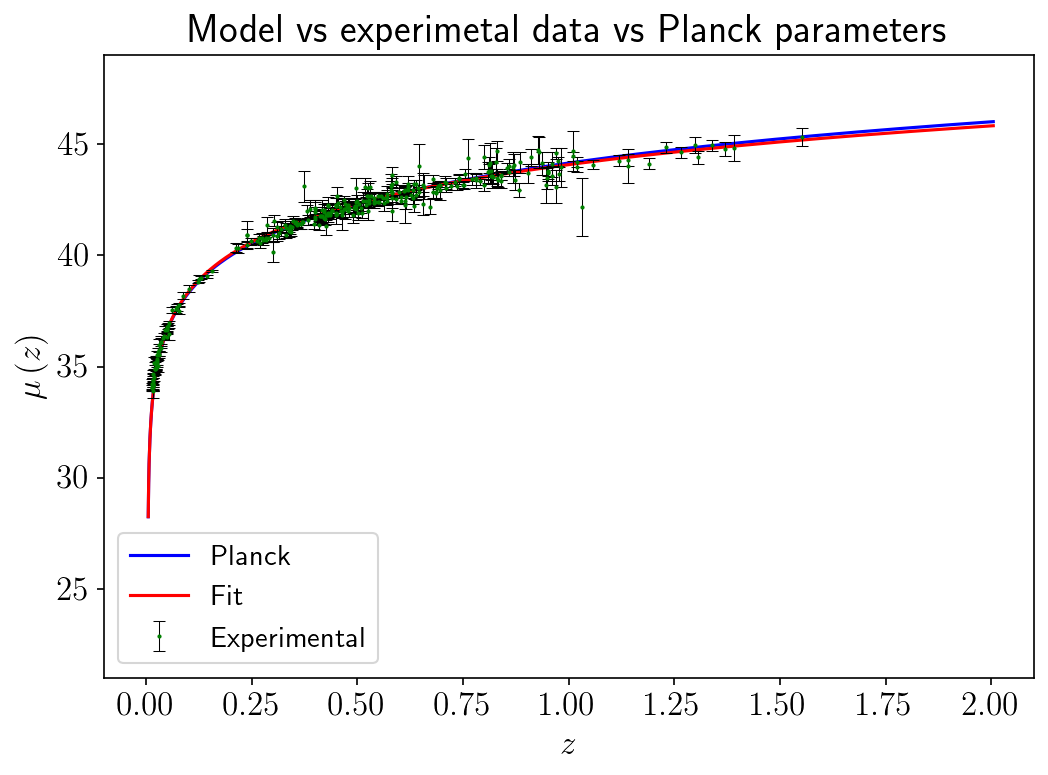

In [299]:
param_names = [r"$\Omega_\Lambda$",r"$\omega_0$", r"$\omega_1$"]

samples = sampler.get_chain()
reshaped = np.swapaxes(samples.T, 0, 1)
reshaped.shape

plot_chains_traj(chains = reshaped,
                 param_names = param_names,
                 axis_to_plot = [0,1])

chains_nb = plot_param_chains(chains = reshaped,
                                    param_names = param_names,
                                    burn=500)

dists = triangle_plot(chains_nb = chains_nb,
                      param_names = ["\Omega_\Lambda","\omega_0", "\omega_1"],
                      dpi = 100)

mod_exp_comparison(dists)